In [27]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [28]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import os
path = "/content/drive/MyDrive/weather/weather"
filepaths = []
labels = []
folders = os.listdir(path)
for folder in folders:
  folderpath = os.path.join(path, folder)
  filelist = os.listdir(folderpath)
  for file in filelist:
    filepath = os.path.join(folderpath, file)
    filepaths.append(filepath)
    labels.append(folder)

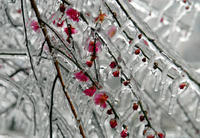

In [30]:
from IPython.display import display, Image
Image(filepaths[3002])

In [31]:
df = pd.DataFrame()
df["filepaths"] = filepaths
df["labels"] = labels
df

,filepaths,labels
0,/content/drive/MyDrive/weather/weather/snow/08...,snow
1,/content/drive/MyDrive/weather/weather/snow/08...,snow
2,/content/drive/MyDrive/weather/weather/snow/08...,snow
3,/content/drive/MyDrive/weather/weather/snow/08...,snow
4,/content/drive/MyDrive/weather/weather/snow/08...,snow
...,...,...
6860,/content/drive/MyDrive/weather/weather/dew/289...,dew
6861,/content/drive/MyDrive/weather/weather/dew/288...,dew
6862,/content/drive/MyDrive/weather/weather/dew/289...,dew
6863,/content/drive/MyDrive/weather/weather/dew/290...,dew


In [32]:
from sklearn.utils import shuffle
filepaths, labels = shuffle(filepaths, labels)


In [33]:
unique_labels = np.unique(labels)
filepaths[:10]

['/content/drive/MyDrive/weather/weather/rainbow/0658.jpg',
 '/content/drive/MyDrive/weather/weather/frost/3637.jpg',
 '/content/drive/MyDrive/weather/weather/frost/3755.jpg',
 '/content/drive/MyDrive/weather/weather/rain/1539.jpg',
 '/content/drive/MyDrive/weather/weather/lightning/1835.jpg',
 '/content/drive/MyDrive/weather/weather/fogsmog/4766.jpg',
 '/content/drive/MyDrive/weather/weather/hail/0447.jpg',
 '/content/drive/MyDrive/weather/weather/sandstorm/3478.jpg',
 '/content/drive/MyDrive/weather/weather/snow/1008.jpg',
 '/content/drive/MyDrive/weather/weather/glaze/6646.jpg']

In [34]:
boolean_labels = [label == np.array(unique_labels) for label in labels]
boolean_labels[1]

array([False, False,  True, False, False, False, False, False, False,
       False, False])

In [35]:
X = filepaths
y = boolean_labels
X_train, X_valid, y_train, y_valid = train_test_split(X[:1000], y[:1000], test_size=0.2, random_state=42)
len(X_train)

800

In [36]:
def process_image(image_path):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=(224,224))
  return image

In [37]:
def get_image_label(image_path, label):
  return process_image(image_path), label

In [38]:
def create_data_batches(X, y=None, test_data=False, valid_data=False):
  if test_data:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(get_image_label).batch(32)
    return data_batch
  elif valid_data:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data_batch = data.map(get_image_label).batch(32)
    return data_batch
  else:
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data_batch = data.map(get_image_label).batch(32)
    return data_batch


In [39]:
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_valid, y_valid, valid_data=True)
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [40]:
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 11), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 11), dtype=tf.bool, name=None)))

In [41]:
INPUT_SHAPE = [None, 224, 224, 3]
OUTPUT_SHAPE = len(unique_labels)
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [42]:
def create_model(model_url = MODEL_URL):
  model = tf.keras.Sequential([hub.KerasLayer(MODEL_URL),
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax")])

  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

  model.build(INPUT_SHAPE)
  return model

In [43]:
model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_2 (Dense)             (None, 11)                11022     
                                                                 
Total params: 5443735 (20.77 MB)
Trainable params: 11022 (43.05 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________


In [44]:
import datetime
def create_tensorboard_callbacks():
  logdir = os.path.join("drive/MyDrive/weather/logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience = 3)

In [45]:
def train_model():
  model = create_model()
  tensorboard = create_tensorboard_callbacks()

  model.fit(x=train_data,
            epochs=100,
            validation_data=valid_data,
            validation_freq=1,
            callbacks= [tensorboard, early_stopping])
  return model

In [46]:
model = train_model()

Epoch 1/100
25/25 [==============================] - 247s 10s/step - loss: 2.0151 - accuracy: 0.4087 - val_loss: 0.9046 - val_accuracy: 0.6700
Epoch 2/100
25/25 [==============================] - 5s 198ms/step - loss: 0.7361 - accuracy: 0.7738 - val_loss: 0.5910 - val_accuracy: 0.8100
Epoch 3/100
25/25 [==============================] - 5s 187ms/step - loss: 0.4574 - accuracy: 0.8675 - val_loss: 0.5434 - val_accuracy: 0.8100
Epoch 4/100
25/25 [==============================] - 6s 229ms/step - loss: 0.3331 - accuracy: 0.8963 - val_loss: 0.5207 - val_accuracy: 0.8350
Epoch 5/100
25/25 [==============================] - 6s 231ms/step - loss: 0.2514 - accuracy: 0.9463 - val_loss: 0.4972 - val_accuracy: 0.8300
Epoch 6/100
25/25 [==============================] - 5s 187ms/step - loss: 0.2061 - accuracy: 0.9550 - val_loss: 0.4930 - val_accuracy: 0.8100
Epoch 7/100
25/25 [==============================] - 6s 248ms/step - loss: 0.1705 - accuracy: 0.9675 - val_loss: 0.4991 - val_accuracy: 0.8250

In [ ]:
%load_ext tensorboard
%tensorboard --logdir drive/MyDrive/weather/logs

In [47]:
predictions = model.predict(valid_data, verbose=1)
predictions[0]

7/7 [==============================] - 16s 153ms/step


array([9.9614978e-01, 1.0754938e-07, 2.3800750e-04, 7.9400397e-06,
       1.1603675e-04, 7.8048806e-06, 1.7070032e-03, 1.6368839e-03,
       4.1649892e-06, 3.8199464e-06, 1.2846119e-04], dtype=float32)

In [48]:
predictions.shape

(200, 11)

In [49]:
def get_pred_label(pred_poss):
  return unique_labels[np.argmax(pred_poss)]

In [50]:
def unbatch_data(data):
  images = []
  labels = []
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_labels[np.argmax(label)])
  return images, labels

In [51]:
val_images, val_labels = unbatch_data(valid_data)
val_images[0], val_labels[0]

(array([[[0.9960785 , 0.9960785 , 0.9960785 ],
         [0.9960785 , 0.9960785 , 0.9960785 ],
         [0.9960785 , 0.9960785 , 0.9960785 ],
         ...,
         [0.9960785 , 0.9960785 , 0.9960785 ],
         [0.9960785 , 0.9960785 , 0.9960785 ],
         [0.9960785 , 0.9960785 , 0.9960785 ]],
 
        [[0.9960785 , 0.9960785 , 0.9960785 ],
         [0.9960785 , 0.9960785 , 0.9960785 ],
         [0.9960785 , 0.9960785 , 0.9960785 ],
         ...,
         [0.9960785 , 0.9960785 , 0.9960785 ],
         [0.9960785 , 0.9960785 , 0.9960785 ],
         [0.9960785 , 0.9960785 , 0.9960785 ]],
 
        [[0.9960785 , 0.9960785 , 0.9960785 ],
         [0.9960785 , 0.9960785 , 0.9960785 ],
         [0.9960785 , 0.9960785 , 0.9960785 ],
         ...,
         [0.9960785 , 0.9960785 , 0.9960785 ],
         [0.9960785 , 0.9960785 , 0.9960785 ],
         [0.9960785 , 0.9960785 , 0.9960785 ]],
 
        ...,
 
        [[0.66554624, 0.82240903, 0.9596639 ],
         [0.66162467, 0.81848747, 0.95574

In [52]:
import matplotlib.pyplot as plt

def plot_pred(pred_poss, labels, images, n=1):
  pred_prob, true_label, image = pred_poss[n], labels[n], images[n]

  pred_label = get_pred_label(pred_prob)

  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  if pred_label == true_label:
    color="green"
  else:
    color="red"

  plt.title("{} {}% ({})".format(pred_label, np.max(pred_prob)*100, true_label), color=color)


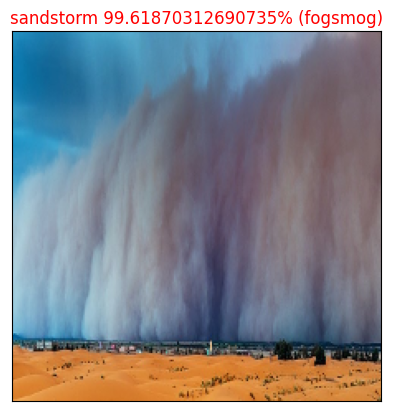

In [53]:
plot_pred(predictions, labels, val_images, n=5)

In [54]:
def plot_pred_conf(pred_poss, labels, n=1):
  pred_prob, true_label = pred_poss[n], labels[n]

  pred_label = get_pred_label(pred_prob)

  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  top_10_pred_labels = unique_labels[top_10_pred_indexes]

  top_plot = plt.bar(np.arange(len(top_10_pred_labels)),
                     top_10_pred_values,
                     color="grey")

  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

<function matplotlib.pyplot.show(close=None, block=None)>

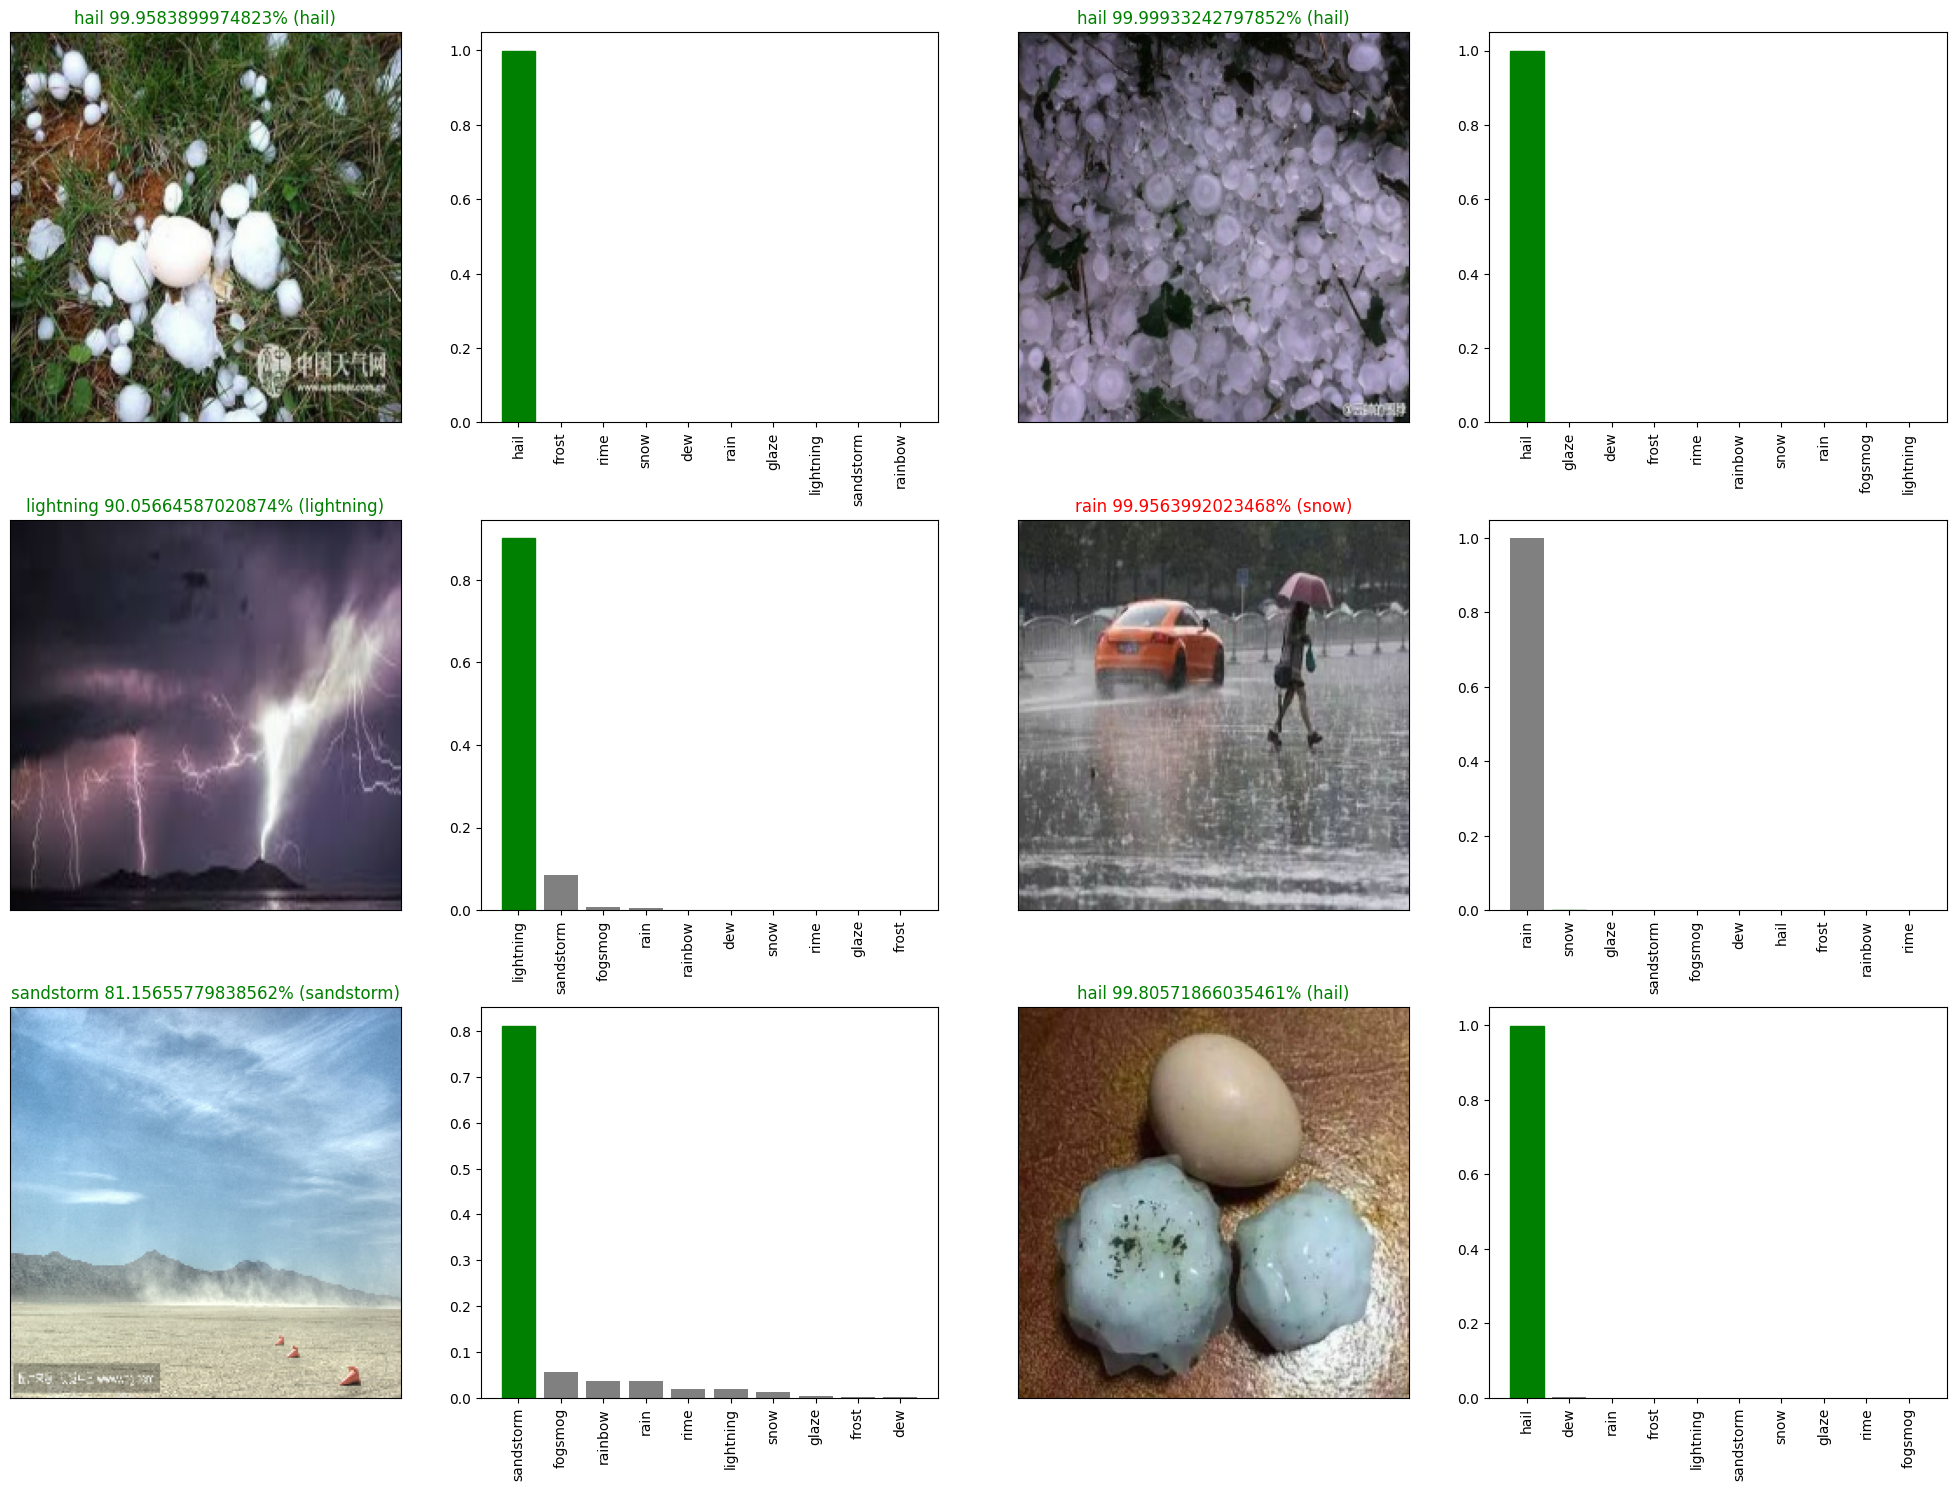

In [ ]:
i_multiplier = 10
rows=3
columns=2
num_images=rows*columns
plt.figure(figsize=(10*columns, 5*rows))

for i in range(num_images):
  plt.subplot(rows, 2*columns, 2*i+1)
  plot_pred(pred_poss=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(rows, 2*columns, 2*i+2)
  plot_pred_conf(pred_poss=predictions,
            labels=val_labels,
            n=i+i_multiplier)

plt.tight_layout(h_pad=1.0)
plt.show

In [ ]:
def save_model(model, suffix=None):
  modeldir = os.path.join("drive/MyDrive/weather/models", datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))

  model_path = modeldir + "-" + suffix + ".h5"
  model.save(model_path)
  return model_path

In [ ]:
def load_model(model_path):
  model = tf.keras.models.load_model(model_path, custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
save_model(model, suffix="1000_images")

In [ ]:
model.evaluate(valid_data)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train)

In [ ]:
full_data = create_data_batches(X_train, y_train)

In [ ]:
full_model = create_model()

In [ ]:
full_model_tensorboard = create_tensorboard_callbacks()

full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy", patience=3)

In [ ]:
len(X)

In [215]:
full_model.fit(x=full_data,
               epochs=100,
               callbacks=[full_model_tensorboard,full_model_early_stopping])

Epoch 1/100
  1/172 [..............................] - ETA: 20:43 - loss: 3.9190 - accuracy: 0.0625

InvalidArgumentError: Graph execution error:

Detected at node DecodeJpeg defined at (most recent call last):
<stack traces unavailable>
Trying to decode BMP format using a wrong op. Use `decode_bmp` or `decode_image` instead. Op used: DecodeJpeg
	 [[{{node DecodeJpeg}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_333186]

In [ ]:
save_model(full_model, suffix="full_data")

In [ ]:
test_data = create_data_batches(X=X_valid, y=y_valid, test_data=True)

In [ ]:
full_model.evaluate(test_data)